In [1]:
import os
import requests
import zipfile
import tarfile

#@save
DATA_HUB = dict()

#@save
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [2]:
#@save
def util_download(url, path=None, verify_ssl=True):
    """Download a given URL
    """
    if path is None:
        fname = url.split('/')[-1]
        # Empty filenames are invalid
        assert fname, 'Can\'t construct file-name from this URL. ' \
            'Please set the `path` option manually.'
    else:
        path = os.path.expanduser(path)
        if os.path.isdir(path):
            fname = os.path.join(path, url.split('/')[-1])
        else:
            fname = path

    if not verify_ssl:
        warnings.warn(
            'Unverified HTTPS request is being made (verify_ssl=False). '
            'Adding certificate verification is strongly advised.')

    print('Downloading {} from {}...'.format(fname, url))
    r = requests.get(url, stream=True, verify=verify_ssl)
    with open(fname, 'wb') as f:
        f.write(r.content)

    return fname

#@save
def download(name, cache_dir=os.path.join('..', 'data')):
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, "%s does not exist" % name
    url, sha1 = DATA_HUB[name]
    d2l.mkdir_if_not_exist(cache_dir)
    return util_download(url)

In [3]:
# If pandas is not installed, please uncomment the following line:
# !pip install pandas

%matplotlib inline
from d2l import torch as d2l
import torch
import torch.nn as nn
import pandas as pd
import numpy as np

In [4]:
#@save
DATA_HUB['kaggle_house_train'] = (
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

#@save
DATA_HUB['kaggle_house_test'] = (
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [5]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [6]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [7]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [8]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [9]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# After standardizing the data all means vanish, hence we can set missing
# values to 0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [10]:
# Dummy_na=True refers to a missing value being a legal eigenvalue, and
# creates an indicative feature for it
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [11]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values,
                              dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values,
                             dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values,
                            dtype=torch.float32).reshape(-1, 1)

In [12]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

In [13]:
def log_rmse(net,features,labels):
    # To further stabilize the value when the logarithm is taken, set the
    # value less than 1 as 1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(torch.mean(loss(torch.log(clipped_preds),
                                       torch.log(labels))))
    return rmse.item()

In [14]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # The Adam optimization algorithm is used here
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            outputs = net(X)
            l = loss(outputs,y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [15]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
    return X_train, y_train, X_valid, y_valid

In [16]:
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs+1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse',
                     legend=['train', 'valid'], yscale='log')
        print('fold %d, train rmse: %f, valid rmse: %f' % (
            i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

fold 0, train rmse: 0.170968, valid rmse: 0.156636
fold 1, train rmse: 0.162647, valid rmse: 0.190230
fold 2, train rmse: 0.164420, valid rmse: 0.168527
fold 3, train rmse: 0.167824, valid rmse: 0.154938
fold 4, train rmse: 0.163568, valid rmse: 0.183360
5-fold validation: avg train rmse: 0.165886, avg valid rmse: 0.170738


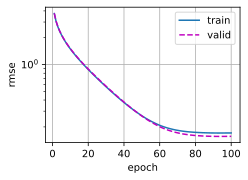

In [17]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print('%d-fold validation: avg train rmse: %f, avg valid rmse: %f'
      % (k, train_l, valid_l))

In [18]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='rmse', yscale='log')
    print('train rmse %f' % train_ls[-1])
    # Apply the network to the test set
    preds = net(test_features).detach().numpy()
    # Reformat it for export to Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

train rmse 0.162559


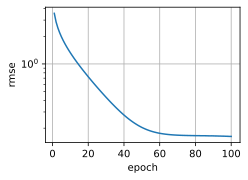

In [19]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)